In [3]:
upos_maps={'a':'ADJ', 'p':'ADP', 'd':'ADV',
           'u':'AUX', 'c':'CCONJ', 'h':'DET',
           'e':'INTJ', 'n':'NOUN', 'm':'NUM',
           'z':'PART', 'r':'PRON', 'nh':'PROPN',
           'wp':'PUNCT', 'ws':'SYM',
           'v':'VERB', 'x':'X'
          }
upos_rev_maps={'SCONJ':['c'], 'NOUN':['ni', 'nl', 'ns', 'nt', 'nz', 'n', 'nd', 'nh']}

def get_pos_mapping(pos, default_val='X'):
    if pos in upos_maps:
        return upos_maps[pos]
    else:
        for k, v in upos_rev_maps.items():
            if pos in v:
                return k
    return default_val

get_pos_mapping('v')

'VERB'

In [6]:
from concurrent import futures
import time

import grpc
import nlpserv_pb2
import nlpserv_pb2_grpc

def nlp_procs(p, func):
    # NOTE(gRPC Python Team): .close() is possible on a channel and should be
    # used in circumstances in which the with statement does not fit the needs
    # of the code.
    # with grpc.insecure_channel('localhost:10052') as channel:
    with grpc.insecure_channel(
            target='localhost:10052',
            options=[('grpc.lb_policy_name', 'pick_first'),
                     ('grpc.enable_retries', 0), ('grpc.keepalive_timeout_ms',
                                                  10000)]) as channel:
        stub = nlpserv_pb2_grpc.NlpProcsStub(channel)
        response = func(stub, p)
    # print("Greeter client received: " + response.message)
    return response

def get_head_lemma(tree, id):
    if id==0:
        return "_core_"
    for word in result.words:
        if word.id==id:
            return word.lemma

text="徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。"
result=nlp_procs(text, lambda stub, s: stub.ParseDependency(nlpserv_pb2.NlParseRequest(text=s)))   
for word in result.words:
    print(word.id, word.lemma, word.name, word.deprel, word.head_id, \
          get_head_lemma(result, word.head_id),
          "%s[%s]"%(word.postag2, get_pos_mapping(word.postag2)), 
          word.postag1
         )

1 徐先生 未##人 sbv 4 帮助 nh[PROPN] nr
2 还 还 adv 4 帮助 d[ADV] d
3 具体 具体 adv 4 帮助 a[ADJ] ad
4 帮助 帮助 hed 0 _core_ v[VERB] v
5 他 他 dbl 4 帮助 r[PRON] r
6 确定 确定 vob 4 帮助 v[VERB] v
7 了 了 rad 6 确定 u[AUX] u
8 把 把 adv 15 作为 p[ADP] p
9 画 画 pob 8 把 v[VERB] v
10 雄鹰 雄鹰 vob 9 画 n[NOUN] n
11 、 、 wp 12 松鼠 wp[PUNCT] w
12 松鼠 松鼠 coo 10 雄鹰 n[NOUN] n
13 和 和 lad 14 麻雀 c[CCONJ] c
14 麻雀 麻雀 coo 10 雄鹰 n[NOUN] n
15 作为 作为 vob 6 确定 v[VERB] v
16 主攻 主攻 att 17 目标 v[VERB] vn
17 目标 目标 vob 15 作为 n[NOUN] n
18 。 。 wp 4 帮助 wp[PUNCT] w


In [7]:
from sagas.nlu.uni_intf import RootWordImpl, WordIntf, SentenceIntf

class HanlpWordImpl(WordIntf):
    def setup(self, token):
        # print(word.id, word.lemma, word.deprel, word.head_id, \
        #  get_head_lemma(result, word.head_id))        
        governor = token.head_id
        idx = token.id  # start from 1
        features = {'index': idx, 'text': token.name, 'lemma': token.lemma,
                    'upos': get_pos_mapping(token.postag2), 'xpos': token.postag2,
                    'feats': [token.postag1], 'governor': governor, 'dependency_relation': token.deprel,
                    'entity': []
                    }
        return features


class HanlpSentImpl(SentenceIntf):
    def setup(self, sent):
        words = []
        for word in sent.words:
            words.append(HanlpWordImpl(word))
        deps = []
        return words, deps

class HanlpParserImpl(object):
    def __init__(self, lang):
        self.lang = lang

    def __call__(self, sents):
        doc = nlp_procs(sents, lambda stub, s: stub.ParseDependency(nlpserv_pb2.NlParseRequest(text=s))) 
        return HanlpSentImpl(doc)


❶ verb_domains(帮助) _


,rel,index,text,lemma,children,features
0,sbv,1,未##人,徐先生,[未##人],"[c_propn, x_nh]"
1,adv,2,还,还,[还],"[c_adv, x_d]"
2,adv,3,具体,具体,[具体],"[c_adj, x_a]"
3,dbl,5,他,他,[他],"[c_pron, x_r]"
4,vob,6,确定,确定,"[确定, 了, 把, 画, 雄鹰, 、, 松鼠, 和, 麻雀, 作为, 主攻, 目标]","[c_verb, x_v]"
5,wp,18,。,。,[。],"[c_punct, x_wp]"


vob -> 确定 了 把 画 雄鹰 、 松鼠 和 麻雀 作为 主攻 目标
❷ verb_domains(确定) _


,rel,index,text,lemma,children,features
0,rad,7,了,了,[了],"[c_aux, x_u]"
1,vob,15,作为,作为,"[把, 画, 雄鹰, 、, 松鼠, 和, 麻雀, 作为, 主攻, 目标]","[c_verb, x_v]"


vob -> 把 画 雄鹰 、 松鼠 和 麻雀 作为 主攻 目标
❸ verb_domains(画) _


,rel,index,text,lemma,children,features
0,vob,10,雄鹰,雄鹰,"[雄鹰, 、, 松鼠, 和, 麻雀]","[c_noun, x_n]"


vob -> 雄鹰 、 松鼠 和 麻雀
❹ verb_domains(作为) _


,rel,index,text,lemma,children,features
0,adv,8,把,把,"[把, 画, 雄鹰, 、, 松鼠, 和, 麻雀]","[c_adp, x_p]"
1,vob,17,目标,目标,"[主攻, 目标]","[c_noun, x_n]"


adv -> 把 画 雄鹰 、 松鼠 和 麻雀
vob -> 主攻 目标
❺ verb_domains(主攻) _


,rel,index,text,lemma,children,features


index: 1	text: 未##人 	lemma: 徐先生	upos: PROPN	xpos: nh
index: 2	text: 还 	lemma: 还	upos: ADV	xpos: d
index: 3	text: 具体 	lemma: 具体	upos: ADJ	xpos: a
index: 4	text: 帮助 	lemma: 帮助	upos: VERB	xpos: v
index: 5	text: 他 	lemma: 他	upos: PRON	xpos: r
index: 6	text: 确定 	lemma: 确定	upos: VERB	xpos: v
index: 7	text: 了 	lemma: 了	upos: AUX	xpos: u
index: 8	text: 把 	lemma: 把	upos: ADP	xpos: p
index: 9	text: 画 	lemma: 画	upos: VERB	xpos: v
index: 10	text: 雄鹰 	lemma: 雄鹰	upos: NOUN	xpos: n
index: 11	text: 、 	lemma: 、	upos: PUNCT	xpos: wp
index: 12	text: 松鼠 	lemma: 松鼠	upos: NOUN	xpos: n
index: 13	text: 和 	lemma: 和	upos: CCONJ	xpos: c
index: 14	text: 麻雀 	lemma: 麻雀	upos: NOUN	xpos: n
index: 15	text: 作为 	lemma: 作为	upos: VERB	xpos: v
index: 16	text: 主攻 	lemma: 主攻	upos: VERB	xpos: v
index: 17	text: 目标 	lemma: 目标	upos: NOUN	xpos: n
index: 18	text: 。 	lemma: 。	upos: PUNCT	xpos: wp
未##人 -> sbv, 4, 帮助
还 -> adv, 4, 帮助
具体 -> adv, 4, 帮助
帮助 -> hed, 0, _root_
他 -> dbl, 4, 帮助
确定 -> vob, 4, 帮助
了 -> rad, 6, 确定
把 -> adv, 15, 作

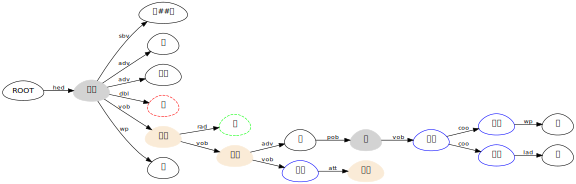

In [8]:
from sagas.nlu.uni_cli import UniCli
from sagas.nlu.uni_viz import EnhancedViz
from sagas.nlu.corenlp_parser import get_chunks
from sagas.tool.misc import print_stem_chunks
import sagas

serial_numbers='❶❷❸❹❺❻❼❽❾❿'
local=False
parser=HanlpParserImpl
def viz_sample(lang, sents):
    from sagas.nlu.uni_remote import dep_parse
    
    doc=parser(lang)(sents)
    rs = get_chunks(doc)
    
    for serial, r in enumerate(rs):
        df = sagas.to_df(r['domains'], ['rel', 'index', 'text', 'lemma', 'children', 'features'])
        if 'head' in r:
            cla="%s(%s)"%(r['head'], r['head_pos'])
        else:
            cla='_'
        print(serial_numbers[serial], '%s(%s)' % (r['type'], r['lemma']), cla)
        # sagas.print_df(df)
        display(df)
        print_stem_chunks(r)

    cv = EnhancedViz(shape='egg', size='8,5', fontsize=20)
    return cv.analyse_doc(doc, None)

sents="徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。"
viz_sample('zh', sents)

❶ verb_domains(关掉) _


,rel,index,text,lemma,children,features
0,sbv,1,我,我,[我],"[c_pron, x_r]"
1,adv,2,必须,必须,[必须],"[c_adv, x_d]"
2,vob,7,灯,灯,"[房间, 里, 的, 灯]","[c_noun, x_n]"
3,wp,8,。,。,[。],"[c_punct, x_wp]"


vob -> 房间 里 的 灯
index: 1	text: 我 	lemma: 我	upos: PRON	xpos: r
index: 2	text: 必须 	lemma: 必须	upos: ADV	xpos: d
index: 3	text: 关掉 	lemma: 关掉	upos: VERB	xpos: v
index: 4	text: 房间 	lemma: 房间	upos: NOUN	xpos: n
index: 5	text: 里 	lemma: 里	upos: NOUN	xpos: nd
index: 6	text: 的 	lemma: 的	upos: AUX	xpos: u
index: 7	text: 灯 	lemma: 灯	upos: NOUN	xpos: n
index: 8	text: 。 	lemma: 。	upos: PUNCT	xpos: wp
我 -> sbv, 3, 关掉
必须 -> adv, 3, 关掉
关掉 -> hed, 0, _root_
房间 -> att, 5, 里
里 -> att, 7, 灯
的 -> rad, 5, 里
灯 -> vob, 3, 关掉
。 -> wp, 3, 关掉
('我', 3, 'sbv')
('必须', 3, 'adv')
('关掉', 0, 'hed')
('房间', 5, 'att')
('里', 7, 'att')
('的', 5, 'rad')
('灯', 3, 'vob')
('。', 3, 'wp')


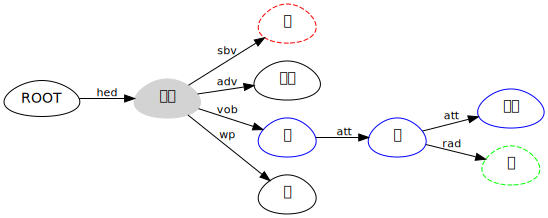

In [9]:
viz_sample('zh', '我必须关掉房间里的灯。')